In [ ]:
# Install Modules

!pip install -U LibRecommender
!pip install libreco
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement libreco (from versions: none)
ERROR: No matching distribution found for libreco


In [ ]:
# IMport Modules

import random
import warnings
import zipfile
from pathlib import Path

import pandas as pd
import tensorflow as tf
import tqdm

warnings.filterwarnings("ignore")

In [ ]:
# Load Base folder

from google.colab import drive
drive.mount('/content/drive')

BASE_FOLDER = '/content/drive/MyDrive/ProjectDatasets'

Mounted at /content/drive


In [ ]:
## Bring in the Data

def load_ml_1m():
    # download and extract zip file
    tf.keras.utils.get_file(
        "ml-1m.zip",
        "http://files.grouplens.org/datasets/movielens/ml-1m.zip",
        cache_dir=".",
        cache_subdir=".",
        extract=True,
    )

    # read and merge data into same table
    cur_path = Path(".").absolute()

    #Ratings
    ratings = pd.read_csv(
        cur_path / "ml-1m" / "ratings.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "item", "rating", "time"],
    )

    #Users
    users = pd.read_csv(
        cur_path / "ml-1m" / "users.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "sex", "age", "occupation"],
    )

    # Movies
    items = pd.read_csv(
        cur_path / "ml-1m" / "movies.dat",
        sep="::",
        usecols=[0, 2],
        names=["item", "genre"],
        encoding="iso-8859-1",
    )

    items[["genre1", "genre2", "genre3"]] = (
        items["genre"].str.split(r"|", expand=True).fillna("missing").iloc[:, :3]
    )

    # Remove Duplicates
    items.drop("genre", axis=1, inplace=True)

    #Merged Data
    data = ratings.merge(users, on="user").merge(items, on="item")

    #Rename Rating Here as Label
    data.rename(columns={"rating": "label"}, inplace=True)

    #data = pd.merge(data, reviews, on='item')

    # random shuffle data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    return data

data = load_ml_1m()

5917549/5917549 [==============================] - 0s 0us/step


In [ ]:
data = load_ml_1m()
print("data shape:", data.shape)

data shape: (1000209, 10)


In [ ]:
data.iloc[random.choices(range(len(data)), k=10)]  # randomly select 10 rows

,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
97950,59,318,3,977934038,F,50,1,Drama,missing,missing
231198,3721,1288,4,966226250,M,25,15,Comedy,Drama,Musical
350658,1845,506,4,974712098,M,25,2,Drama,missing,missing
325007,3464,2551,4,967174774,F,25,14,Drama,Thriller,missing
658883,5424,3259,4,970016427,F,35,2,Drama,Romance,missing
608188,5744,480,4,959993979,F,25,4,Action,Adventure,Sci-Fi
834281,5000,293,4,962594795,M,25,4,Crime,Drama,Romance
688006,928,2997,5,975193891,F,56,16,Comedy,missing,missing
604398,2181,222,1,979353491,M,25,0,Drama,Romance,missing
286000,4890,593,5,962739673,F,25,1,Drama,Thriller,missing


Load Reviews Data

In [ ]:
# Load movie review data with sentiment scores

columns = ["review", "scores", "sentiment", "user", "item"]
file_path = '/content/drive/MyDrive/ProjectDatasets/imdb/scored/reviews_dataset_rumss.csv'

In [ ]:
# Load reviews
m_reviews = pd.read_csv(file_path, names=columns)

In [ ]:
m_reviews.sample(3)

,review,scores,sentiment,user,item
19822,This is only a response to the yahoo who says ...,1,slighly negative,1277,2122
15475,I actually went into this film with some expec...,1,slighly negative,4303,1243
6990,This stirring western spins the tale of the fa...,3,slightly positive,4544,3196


In [ ]:
# Convert 'user' and 'item' columns to numeric type (with errors='coerce' to handle non-numeric values)
m_reviews['user'] = pd.to_numeric(m_reviews['user'], errors='coerce')
m_reviews['item'] = pd.to_numeric(m_reviews['item'], errors='coerce')
m_reviews['scores'] = pd.to_numeric(m_reviews['scores'], errors='coerce')

# Convert NaN values to integer (if desired)
m_reviews['user'] = m_reviews['user'].fillna(0).astype(int)
m_reviews['item'] = m_reviews['item'].fillna(0).astype(int)
#m_reviews['scores'] = m_reviews['scores'].fillna(0).astype(int)

In [ ]:
m_reviews.sample(3)

,review,scores,sentiment,user,item
19961,This has to be my favourite film. The script i...,4.0,positive,4510,2088
5130,The story for the first-aired television insta...,3.0,slightly positive,855,2795
52195,amazing well stills holds well today film seem...,4.0,positive,4390,3178


In [ ]:
m_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57982 entries, 0 to 57981
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     57980 non-null  object 
 1   scores     57981 non-null  float64
 2   sentiment  57982 non-null  object 
 3   user       57982 non-null  int64  
 4   item       57982 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
m_reviews = m_reviews.dropna(subset=['scores', 'user', 'item'])

In [ ]:
m_reviews.sample(3)

,review,scores,sentiment,user,item
34147,I jotted down a few notes here on THE FIRST PO...,2.0,neutral,5539,1240
13425,I own this movie. I bought it for $3.99 at a f...,4.0,positive,376,2396
13140,This is one of the classic TWILIGHT ZONE episo...,3.0,slightly positive,5256,3


In [ ]:
#Merged Data
merged_df = pd.merge(m_reviews, data, on=['user', 'item'], how='outer')


In [ ]:
# Drop rows with NaN values
merged_df_no_na = merged_df.dropna()

# Sample 10 rows from the DataFrame containing data
merged_df_no_na.sample(2)

,review,scores,sentiment,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
33826,"This film, once sensational for its forward-th...",1.0,slighly negative,1954,47,4,974690872,M,25,16,Crime,Thriller,missing
10164,the first Child's Play was an original and eff...,1.0,slighly negative,550,1256,5,976066678,M,45,8,Comedy,War,missing


In [ ]:
# Convert NaN values to integer (if desired)
merged_df_no_na['label'] = merged_df_no_na['label'].astype(int)
merged_df_no_na['time'] = merged_df_no_na['time'].astype(int)
merged_df_no_na['scores'] = merged_df_no_na['scores'].astype(int)
merged_df_no_na['age'] = merged_df_no_na['age'].astype(int)
merged_df_no_na['occupation'] = merged_df_no_na['occupation'].astype(int)

In [ ]:
merged_df_no_na.sample(7)

,review,scores,sentiment,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
18002,Great underrated movie great action good actor...,4,positive,4422,2890,3,965788608,M,25,5,Drama,War,missing
22202,What are the movies? I mean.. what are movies ...,3,slightly positive,3665,2288,2,973902075,M,25,0,Action,Horror,Sci-Fi
1896,This movie offers NOTHING to anyone. It doesn'...,0,negative,303,6,4,976503173,M,25,7,Action,Crime,Thriller
39837,Watched this film having really enjoyed Gregor...,1,slighly negative,1765,3273,2,974706794,M,18,4,Horror,Mystery,Thriller
49281,The cover art (which features a man holding a ...,1,slighly negative,3197,2257,3,968636758,F,18,14,Comedy,Romance,missing
19563,Excellent introspective / interpersonal piece ...,4,positive,1555,2888,5,974741288,F,18,0,Comedy,Romance,missing
47908,This last Dutch speaking film of Verhooven mad...,1,slighly negative,3471,3063,1,973299079,M,18,4,Thriller,missing,missing


In [ ]:
# Calculate the number of rows with data in the DataFrame
num_rows_with_data = merged_df_no_na.shape[0]

# Display the number of rows with data
print("Number of rows with data:", num_rows_with_data)


Number of rows with data: 57979


In [ ]:
revamp_df = merged_df_no_na.to_csv('/content/drive/MyDrive/ProjectDatasets/imdb/scored/merged_df.csv',index=False)

In [ ]:
# Drop a column named 'column_to_drop'
rum_ddf = merged_df_no_na.drop(columns=['review','sentiment'])

In [ ]:
rum_ddf.sample(2)

,scores,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
16951,0,712,2012,3,975602050,M,25,0,Comedy,Sci-Fi,Western
44729,3,3107,2997,1,969510373,M,25,17,Comedy,missing,missing


In [ ]:
# Specify the desired order of columns
rum_ddf = pd.DataFrame(rum_ddf)
desired_columns_order = ['user', 'item', *rum_ddf.columns.difference(['user', 'item'])]

# Reorder the columns in the DataFrame
ordered_df = rum_ddf[desired_columns_order]

In [ ]:
ordered_df.sample(10)

,user,item,age,genre1,genre2,genre3,label,occupation,scores,sex,time
24028,2228,2490,25,Action,Thriller,missing,4,12,2,M,974597798
15425,2124,3508,25,Western,missing,missing,5,0,2,M,974649498
55160,718,2959,18,Drama,missing,missing,3,2,4,M,975529089
47316,893,42,50,Action,Crime,Drama,2,6,1,F,975228593
49947,2838,1348,18,Horror,missing,missing,4,1,3,M,972570980
9545,192,266,18,Drama,Romance,War,3,1,0,M,977026340
21014,5675,1198,35,Action,Adventure,missing,5,14,0,M,958690662
9036,199,2427,18,Action,Drama,War,1,4,2,M,976977100
46463,1501,174,25,Comedy,missing,missing,3,11,1,M,974929941
33935,3339,3448,25,Comedy,Drama,War,4,17,4,M,967823067


Define What label and scores does

In [ ]:
def score_to_sentiment(value):
    if value == 0:
      return "negative"
    elif value == 1:
      return "slighly negative"
    elif value == 2:
      return "neutral"
    elif value == 3:
      return "slightly positive"
    else:
      return "positive"

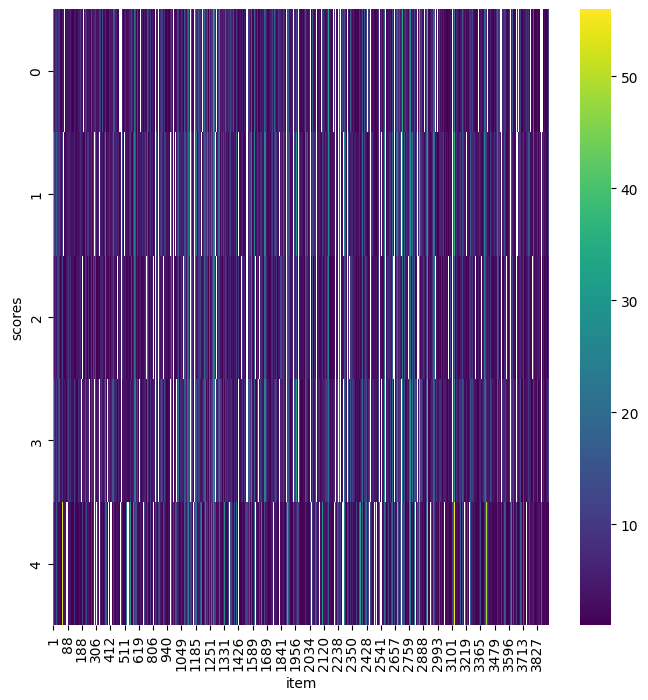

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
ordered_dfdhist = pd.DataFrame({
    x_label: grp['scores'].value_counts()
    for x_label, grp in ordered_df.groupby('item')
})
sns.heatmap(ordered_dfdhist, cmap='viridis')
plt.xlabel('item')
_ = plt.ylabel('scores')

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['scores'].value_counts()
    for x_label, grp in _df_3.groupby('movieid')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('movieid')
_ = plt.ylabel('scores')

REFINED

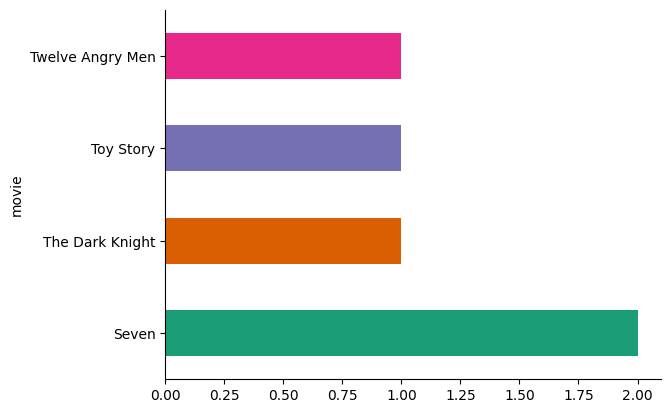

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('movie').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['genre1'].value_counts()
    for x_label, grp in _df_20.groupby('sex')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('sex')
_ = plt.ylabel('genre1')

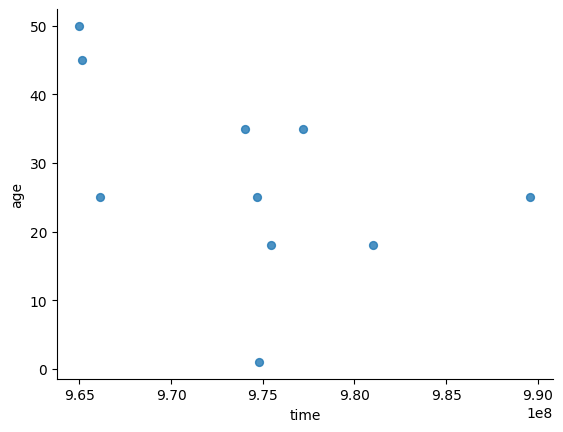

In [ ]:
from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='time', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ordered_df = pd.DataFrame(ordered_df)


In [ ]:
ordered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57979 entries, 0 to 57980
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user        57979 non-null  int64 
 1   item        57979 non-null  int64 
 2   age         57979 non-null  int64 
 3   genre1      57979 non-null  object
 4   genre2      57979 non-null  object
 5   genre3      57979 non-null  object
 6   label       57979 non-null  int64 
 7   occupation  57979 non-null  int64 
 8   scores      57979 non-null  int64 
 9   sex         57979 non-null  object
 10  time        57979 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 5.3+ MB


In [ ]:
ordered_df.to_csv('/content/drive/MyDrive/ProjectDatasets/imdb/scored/final_file_df.csv',index=False)

In [ ]:
final_data = pd.read_csv('/content/drive/MyDrive/ProjectDatasets/imdb/scored/final_file_df.csv')

In [ ]:
final_data.sample(4)

,user,item,age,genre1,genre2,genre3,label,occupation,scores,sex,time
32098,5762,1436,35,Comedy,missing,missing,3,6,1,F,958224235
39006,3995,2455,35,Horror,Sci-Fi,missing,4,17,0,M,965585056
23108,123,1952,35,Drama,missing,missing,3,9,1,M,977448163
8326,5868,1131,35,Drama,missing,missing,5,14,1,M,957574108


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user        1000209 non-null  int64 
 1   item        1000209 non-null  int64 
 2   label       1000209 non-null  int64 
 3   time        1000209 non-null  int64 
 4   sex         1000209 non-null  object
 5   age         1000209 non-null  int64 
 6   occupation  1000209 non-null  int64 
 7   genre1      1000209 non-null  object
 8   genre2      1000209 non-null  object
 9   genre3      1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 76.3+ MB


In [ ]:
# SPlit Data

from libreco.data import random_split

# split data into three folds for training, evaluating and testing
first_half_data = data[: (len(data) // 2)] #I am using Full Data
train_data, eval_data, test_data = random_split(first_half_data, multi_ratios=[0.6, 0.2, 0.2], seed=42)

In [ ]:
print("first half data shape:", first_half_data.shape)

first half data shape: (500104, 10)


In [ ]:
from libreco.data import DatasetFeat

sparse_col = ["sex", "occupation", "genre1", "genre2", "genre3"]
dense_col = ["age", "label"]
# dense_col = ["age", "label", "scores"]
user_col = ["sex", "age", "label", "occupation"]
#user_col = ["sex", "age", "label", "scores", "occupation"]
item_col = ["genre1", "genre2", "genre3"]

train_data, data_info = DatasetFeat.build_trainset(train_data, user_col, item_col, sparse_col, dense_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)

In [ ]:
print(type(train_data))

<class 'libreco.data.transformed.TransformedSet'>


In [ ]:
#train_data, data_info = DatasetFeat.build_trainset(train_data, user_col, item_col, sparse_col, dense_col)
#eval_data = DatasetFeat.build_evalset(eval_data)
#test_data = DatasetFeat.build_testset(test_data)

In [ ]:
print(data_info)

n_users: 2737, n_items: 1882, data density: 0.7879 %


In [ ]:
#Import DeepFM
from libreco.algorithms import DeepFM
import tensorflow as tf

tf.compat.v1.reset_default_graph()

# n_epochs=4,
# dropout_rate=None,

model = DeepFM(
    task="ranking",             # Use ranking task if appropriate
    data_info=data_info,        # Provide dataset information
    loss_type="cross_entropy",  # Use cross-entropy loss for classification tasks
    embed_size=16,              # Size of embedding vectors = 16 or 8
    n_epochs= 12,                # Increase the number of epochs for larger datasets - 5 or 12
    lr=1e-4,                    # Adjust learning rate accordingly 1e-4 or 0.001
    lr_decay=True,              # Enable learning rate decay for better convergence
    reg=None,                  # Apply regularization to prevent overfitting
    batch_size=1024,            # Adjust batch size based on available memory = 512 or 2048 or 1024
    num_neg=1,                  # Increase the number of negative samples for ranking tasks
    use_bn=False,                # Use batch normalization to stabilize training
    dropout_rate=None,           # Apply dropout regularization to prevent overfitting
    hidden_units=(256, 128, 64), # Increase the size of hidden layers for more capacity
    tf_sess_config=None,         # Use default TensorFlow session configuration
)

# Fit Model

model.fit(
    train_data=train_data,
    neg_sampling=True,  # perform negative sampling on training and eval data
    verbose=2,
    shuffle=True,
    eval_data=eval_data,
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

Training start time: 2024-04-12 22:47:11
total params: 242,533 | embedding params: 164,619 | network params: 77,914


train: 100%|██████████| 294/294 [00:04<00:00, 63.32it/s]


Epoch 1 elapsed: 4.650s
	 train_loss: 1.2278


eval_listwise: 100%|██████████| 2984/2984 [00:09<00:00, 308.63it/s]


	 eval log_loss: 0.7456
	 eval balanced_accuracy: 0.5706
	 eval roc_auc: 0.5971
	 eval pr_auc: 0.5779
	 eval precision@10: 0.0279
	 eval recall@10: 0.0217
	 eval map@10: 0.0960
	 eval ndcg@10: 0.1280


train: 100%|██████████| 294/294 [00:01<00:00, 160.72it/s]


Epoch 2 elapsed: 1.837s
	 train_loss: 0.6384


eval_listwise: 100%|██████████| 2984/2984 [00:09<00:00, 316.77it/s]


	 eval log_loss: 0.5766
	 eval balanced_accuracy: 0.7082
	 eval roc_auc: 0.7737
	 eval pr_auc: 0.7418
	 eval precision@10: 0.0430
	 eval recall@10: 0.0367
	 eval map@10: 0.1167
	 eval ndcg@10: 0.1677


train: 100%|██████████| 294/294 [00:01<00:00, 161.74it/s]


Epoch 3 elapsed: 1.826s
	 train_loss: 0.5503


eval_listwise: 100%|██████████| 2984/2984 [00:09<00:00, 329.53it/s]


	 eval log_loss: 0.5417
	 eval balanced_accuracy: 0.7309
	 eval roc_auc: 0.8013
	 eval pr_auc: 0.7673
	 eval precision@10: 0.0491
	 eval recall@10: 0.0437
	 eval map@10: 0.1285
	 eval ndcg@10: 0.1881


train: 100%|██████████| 294/294 [00:02<00:00, 126.51it/s]


Epoch 4 elapsed: 2.330s
	 train_loss: 0.5303


eval_listwise: 100%|██████████| 2984/2984 [00:08<00:00, 342.53it/s]


	 eval log_loss: 0.5351
	 eval balanced_accuracy: 0.7301
	 eval roc_auc: 0.8058
	 eval pr_auc: 0.7726
	 eval precision@10: 0.0509
	 eval recall@10: 0.0458
	 eval map@10: 0.1322
	 eval ndcg@10: 0.1933


train: 100%|██████████| 294/294 [00:02<00:00, 102.62it/s]


Epoch 5 elapsed: 2.870s
	 train_loss: 0.5224


eval_listwise: 100%|██████████| 2984/2984 [00:08<00:00, 336.00it/s]


	 eval log_loss: 0.5301
	 eval balanced_accuracy: 0.7348
	 eval roc_auc: 0.8075
	 eval pr_auc: 0.7741
	 eval precision@10: 0.0527
	 eval recall@10: 0.0467
	 eval map@10: 0.1360
	 eval ndcg@10: 0.1984


In [ ]:
# Evaluate Test Data

from libreco.evaluation import evaluate

evaluate(
    model=model,
    data=test_data,
    neg_sampling=True,  # No negative sampling on test data
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)


eval_listwise: 100%|██████████| 2977/2977 [00:09<00:00, 311.65it/s]


{'loss': 0.5094239725663952,
 'balanced_accuracy': 0.7578452458360426,
 'roc_auc': 0.8345264685484916,
 'pr_auc': 0.8093357714303492,
 'precision': 0.05780987571380583,
 'recall': 0.05315063411788289,
 'map': 0.14349548075802382,
 'ndcg': 0.21146969816696973}

Plots

In [ ]:
# predict preference of user 87711 to item 110
model.predict(user=8711, item=1690)

# Make Recommendation
# model.recommend_user(user=1, n_rec=3)

# Make temporary recommendations based on User features
#model.recommend_user(user=10, n_rec=3, user_feats={"sex": "M", "age": 33})

Detect 1 unknown interaction(s), position: [0]


0.6363509

In [ ]:
data_info.save("/content/drive/MyDrive/ProjectDatasets/", model_name="deep_fm")
model.save("/content/drive/MyDrive/ProjectDatasets/", model_name="deep_fm")